## 语音端点检测

本笔记中包含音量阈值（固定阈值）的端点检测和过零率检测。

以音量为阈值的检测有两种音量可供选择：
1. 计算每一帧语音信号绝对值之和
2. 计算每一帧语音信号的平方对数和（分贝）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import volume as vp
import sounddevice as sd
import math

In [2]:
def simpleEndPointDetection(vol, wave: vp.Wave):
    """一种简单的端点检测方法，首先计算出声波信号的音量（能量），分别以
    音量最大值的10%和音量最小值的10倍为阈值，最后以前两种阈值的一半作为阈值。
    分别找到三个阈值与波形的交点并绘制图形，在查找交点时，各个阈值之间没有相互联系

    figure 1：绘制出声波信号的波形，并分别用 red green blue 三种颜色的竖直线段
    画出检测到的语音信号的端点
    figure 2: 绘制声波音量的波形。并分别用 red green blue 三种颜色的音量阈值横线
    表示出三种不同的阈值。
    """
    # threshold1 = np.max(vol) * 0.10
    # threshold2 = np.min(vol) * 10.0
    # threshold3 = np.max(vol) * 0.05 + np.min(vol) * 5.0
    vmax = np.max(vol)
    vmin = np.min(vol)
    vdiff = vmax - vmin
    # 给出三个固定的阈值
    threshold1 = vmin + vdiff * 0.20
    threshold2 = vmin + vdiff * 0.10
    threshold3 = vmin + vdiff * 0.15
    deltatime = wave.deltatime
    frame = np.arange(0, len(vol)) * deltatime
    
    # 分别找出三个不同的阈值
    index1 = vp.findIndex(vol, threshold1) * deltatime
    index2 = vp.findIndex(vol, threshold2) * deltatime
    index3 = vp.findIndex(vol, threshold3) * deltatime
    end = len(wave.ws) * (1.0 / wave.framerate)
    
    plt.subplot(211)
    plt.plot(wave.ts,wave.ws,color="black")
    if len(index1) > 0:
        plt.plot([index1,index1],[-1,1],'-r')
    if len(index2) > 0:
        plt.plot([index2,index2],[-1,1],'-g')
    if len(index3) > 0:
        plt.plot([index3,index3],[-1,1],'-b')
    plt.ylabel('Amplitude')
    
    plt.subplot(212)
    plt.plot(frame, vol, color="black")
    if len(index1) > 0:
        plt.plot([0,end],[threshold1,threshold1],'-r', label="threshold 1")
    if len(index2) > 0:
        plt.plot([0,end],[threshold2,threshold2],'-g', label="threshold 2")
    if len(index3) > 0:
        plt.plot([0,end],[threshold3,threshold3],'-b', label="threshold 3")
    plt.legend()
    plt.ylabel('Volume(absSum)')
    plt.xlabel('time(seconds)')
    plt.show()

one.wav 是从 `Speech Commands Data Set v0.01` 中拷贝出来的

In [3]:
one = vp.readFile("one.wav", dtype=np.int)

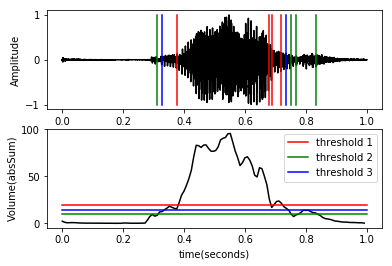

In [4]:
vol = one.normalVolume()
simpleEndPointDetection(vol, one)

In [5]:
def trickPlot(index, color):
    plt.plot([index[::2], index[::2]], [-0.8, 0.8], color)
    plt.plot([index[1::2], index[1::2]], [-1, 1], color)
    
def complexEndPointDetection(vol, wave):
    """只适用于信噪比 > 10db 的简单算法，以总音量区间的 20% 作为第一次判别的阈值，
    找出语音部分。在该阈值基础上，进行第二次阈值判断，第二次的阈值为总音量的 10%。
    第二次阈值判断出的语音信号部分必须包含第一次的语音信号部分，否则认为这不是一个正常的语音帧
    """
    vol = wave.normalVolume()
    deltatime = wave.deltatime
    vmean = np.mean(vol)
    vmax = np.max(vol)
    vmin = np.min(vol)
    vdiff = vmax - vmin
    # threshold1 = vmean - vdiff * 0.20
    # threshold2 = max(vdiff * 0.05 + vmin, vmean - vdiff * 0.4)
    threshold1 = vmin + vdiff * 0.20
    threshold2 = vmin + vdiff * 0.10
    frame = np.arange(0, len(vol)) * deltatime
    end = len(wave.ws) * (1.0 / wave.framerate)

    index1 = vp.findIndex(vol, threshold1)
    #trickPlot(index1 * deltatime, '-r')
    index2 = vp.findIndexWithPreIndex(vol, index1, threshold2)
    
    timeindex1 = index1 * deltatime
    timeindex2 = index2 * deltatime
    
    plt.figure()
    plt.subplot(211)
    plt.plot(wave.ts, wave.ws, color="black")
    # trick plot
    # plt.plot([timeindex1, timeindex1], [-1, 1], '-r')
    trickPlot(timeindex1, '-r')
    trickPlot(timeindex2, '-g')
    plt.ylabel("Amplitude")
    
    plt.subplot(212)
    plt.plot(frame, vol, color="black")
    plt.plot([0, end], [threshold1, threshold1], '-r', label="threshold 1")
    plt.plot([0, end], [threshold2, threshold2], '-g', label="threshold 2")
    plt.legend()
    plt.ylabel("Volume(absSum)")
    plt.xlabel("time(seconds)")
    plt.show()
    return timeindex1, timeindex2

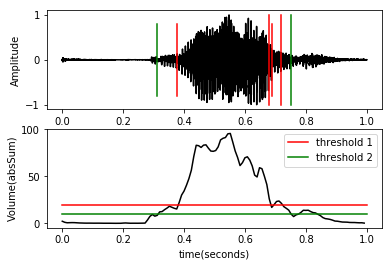

(array([0.376, 0.68 , 0.688, 0.72 ]), array([0.312, 0.752]))

In [6]:
vol = one.normalVolume()
complexEndPointDetection(vol, one)

In [7]:
def zeroCrossRate(wave):
    """通过过零率获取判断出语音帧和非语音部分。
    """
    # 获取波形的过零率
    zcr = wave.zeroCR()
    zcrMax = np.max(zcr)
    zcrMin = np.min(zcr)
    threshold = zcrMin + (zcrMax - zcrMin) * 0.20
    index = vp.findIndex(zcr, threshold)
    timeindex = index * wave.deltatime
    plt.figure()
    plt.subplot(211)
    # wave.plot()
    plt.plot(wave.ts, wave.ws)
    trickPlot(timeindex, '-r')
    plt.ylabel("Wave Form")
    #
    plt.subplot(212)
    # x 为过零率的时间序列，为了和信号的持续时间相同，
    # 在最后计算的时候额外除以 wave.framerate
    x = np.arange(0, len(zcr)) / wave.deltatime / wave.framerate
    plt.plot(x, zcr)
    plt.plot([0, 1], [threshold, threshold], '-r')
    plt.ylabel("Zero Crossing Rate")
    plt.show()
    return timeindex

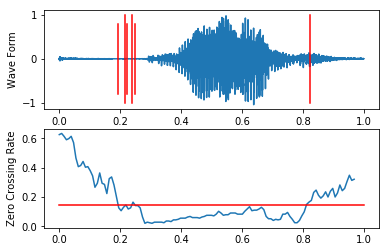

array([0.192, 0.216, 0.224, 0.24 , 0.248, 0.824])

In [8]:
zeroCrossRate(one)

### 参考

[语音信号处理之时域分析-音量及其Python实现](http://ibillxia.github.io/blog/2013/05/15/audio-signal-process-time-domain-volume-python-realization/)